# Fine tuning a Transformers model for NER
The aim of this notebook is to train a Transformer token classification model for the task of NER that consists of finding named entities (Persons, organisations, location etc) in a given string.

Data preparation and training parts of this notebook are creatly inspired by HuggingFace token classification notebook that can be found here:
https://colab.research.google.com/drive/1glUH6nAnalBel6rG3OuvwZI7FjZSnIAd

In [ ]:
!pip install transformers

In [ ]:
!huggingface-cli login

In [ ]:
 !pip install hf-lfs
 !git config --global user.email "you@example.com"
 !git config --global user.name "Your Name"

# Loading a dataset
I use conll 2003 dataset that is available on HuggingFace dataset list

In [2]:
!pip install datasets
from datasets import load_dataset, load_metric

I run a token classification task with 9 labels as seen below. B marks a token that is the beginning of a named entity and I marks a token that is part of a named entity but not the first word. 

In [4]:
datasets["train"].features[f"ner_tags"]

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None)

In [5]:
label_list = datasets["train"].features[f"ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Preparing the data for classification
Transformer models need minimal data preparation steps, nevertheless the data has to be tokenised.

In [ ]:
!pip install transformers
import transformers
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

During the data tokenisation some word units are divided into subwords and some special tokens are added ([CLS], [SEP], a token to let us know that we are performing classification and sentence boundary token). This means that labels need to be aligned witht his new structure.

In [8]:
label_all_tokens = True
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

# Fine-tuning

In order to be able to perform NER task, I fine-tune a BERT model.

In [9]:
len(label_list)

9

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))

In [11]:
model_name = "bert-base-cased"
args = TrainingArguments(
    f"test-ner",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    
  
)

In [8]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

# Metrics

In [ ]:
!pip install seqeval
metric = load_metric("seqeval")

In [14]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# I use trainer class from Pytorch

In [23]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [24]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, id, pos_tags, ner_tags, chunk_tags.
***** Running training *****
  Num examples = 14041
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1317


The following columns in the evaluation set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, id, pos_tags, ner_tags, chunk_tags.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32
Saving model checkpoint to test-ner/checkpoint-500
Configuration saved in test-ner/checkpoint-500/config.json
Model weights saved in test-ner/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-ner/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-ner/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens, id, pos_tags, ner_tags, chunk_tags.
***** Running Evaluation *****
  Num examples = 3250
  Batch size = 32
Saving model checkpoint to test-ner/checkpoint-1000
Configuration saved in test-ner/checkpoint-1000/config.json
Model weights saved in test-ner/checkpoin

TrainOutput(global_step=1317, training_loss=0.10090031982282843, metrics={'train_runtime': 505.1726, 'train_samples_per_second': 83.383, 'train_steps_per_second': 2.607, 'total_flos': 1166128434618210.0, 'train_loss': 0.10090031982282843, 'epoch': 3.0})

# Hyperparameter optimisation
In order to find the best hyperparameters for the model, we need to launch a search.

In [ ]:
!pip install optuna

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
encoded_dataset = datasets.map(tokenize_and_align_labels, batched=True)
def model_init():
    return AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))
# Evaluate during training and a bit more often than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=False)
trainer = Trainer(
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_dataset["train"], 
    eval_dataset=encoded_dataset["validation"], 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

# Defaut objective is the sum of all metrics when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(direction="maximize")

I trained 5 different models and the results can be seen below, I plot precision, recall, F1 and accuracy scores for all the 5 models.

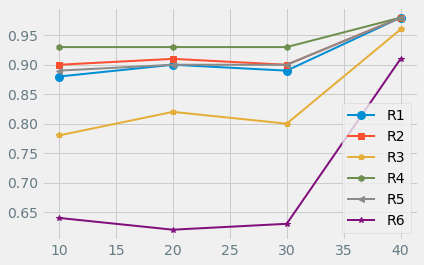

In [44]:
import matplotlib.pyplot as plt
import numpy as np



R1 = [0.88,0.90,0.89,0.98]
R2 = [0.90, 0.91,0.90,0.98]
R3 = [0.78, 0.82,0.80,0.96]
R4 = [0.93,0.93,0.93,0.98]
R5 = [0.89,0.90,0.90,0.98]
R6 = [0.64, 0.62,0.63,0.91]
list_of_markers = ['P','R','F1','A']
y = [10,20,30,40]
  
# plot lines
plt.plot(y, R1, label = "R1", marker='o', markersize = 8, linewidth=2)
plt.plot(y, R2, label = "R2", marker='s',linewidth=2)
plt.plot(y, R3, label = "R3", marker='p',linewidth=2)
plt.plot(y, R4,  label = "R4", marker='h',linewidth=2)
plt.plot(y, R5, label = "R5", marker='<',linewidth=2)
plt.plot(y, R6, label = "R6", marker='*',linewidth=2)


plt.legend()
plt.style.available
plt.style.use('fivethirtyeight')
plt.show()

As seen, the model number 4 had the best results. 

Getting the probabilities

In [9]:
best_model = AutoModelForTokenClassification.from_pretrained("/content/drive/MyDrive/checkpoint", num_labels=len(label_list))

My task is to find the named entities from the phrase and sort them by the model confidence score - how confident the model is in the tag.
I create a NER predictor class for that. 

In [84]:
from collections import defaultdict
class NER_predictor:
  def __init__(self,model, tokenizer,sentence, label_list):
    self.model = model
    self.tokenizer = tokenizer
    self.label_list = label_list
    self.sentence = sentence
  def prepare_data(self):
    tokenized_input = tokenizer(self.sentence, is_split_into_words=False)
    self.tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
  
    self.tensorised_input = tokenizer(sentence, is_split_into_words=False, return_tensors = "pt")
  def align_tokens(self):
    ner_dict = defaultdict()
    
    
    for i, t in enumerate(self.tokens):
      maximum = max(self.probas[i])
      max_idx = self.probas[i].index(maximum)
      label = self.label_list[max_idx]
      if label != 'O':
     
        if t.startswith("##"):
          merged_token = list(ner_dict.keys())[-1]+t[2:]
          ner_dict.popitem()
          ner_dict[merged_token]=(label,self.probas[i][max_idx])
          
        
        else:
          ner_dict[self.tokens[i]]=(label,self.probas[i][max_idx])
  
    return sorted(ner_dict.items(), key=lambda x: x[1][1], reverse = True)
        
    
    
  
  def get_predictions(self):
    outputs = self.model(**self.tensorised_input)
    self.probas = outputs.logits.softmax(dim=-1).tolist()[0]


In [23]:
label_list = ['O', 'PERSON', 'PERSON', 'ORG', 'ORG', 'LOC', 'LOC', 'MISC', 'MISC']
sentence = "Steve Jobs created Apple and loved Harry Potter"
ner = NER_predictor(best_model, tokenizer,sentence, label_list)

In [24]:
ner.prepare_data()

In [25]:
ner.get_predictions()

In [26]:
ner.align_tokens()

[('Jobs', ('PERSON', 0.9998947381973267)),
 ('Steve', ('PERSON', 0.9998737573623657)),
 ('Potter', ('PERSON', 0.9994615912437439)),
 ('Apple', ('ORG', 0.9993703961372375)),
 ('Harry', ('PERSON', 0.9993403553962708))]

In [85]:
label_list = ['O', 'PERSON', 'PERSON', 'ORG', 'ORG', 'LOC', 'LOC', 'MISC', 'MISC']
sentence = "Jeff Bezos went into the space but Elon Musk to Bahamas"
ner = NER_predictor(best_model, tokenizer,sentence, label_list)

In [86]:
ner.prepare_data()

In [87]:
ner.get_predictions()

In [89]:
entity_dict = ner.align_tokens()
for key, (v1,v2) in entity_dict:
  print("The named entity is : {}, its label is : {} and score is : {}".format(key,v1,v2))


The named entity is : Bezos, its label is : PERSON and score is : 0.9998914003372192
The named entity is : Jeff, its label is : PERSON and score is : 0.9998844861984253
The named entity is : Bahamas, its label is : LOC and score is : 0.9998693466186523
The named entity is : Elon, its label is : PERSON and score is : 0.9998254179954529
The named entity is : Musk, its label is : PERSON and score is : 0.9987865090370178
